# Week 11: Feature Engineering & Model Explainability

---

## 🎯 What You'll Learn This Week

Raw data is rarely predictive. Feature engineering transforms data into meaningful signals that models can learn from. Explainability helps us understand why models make predictions.

**Key Concepts:**
- Creating financial features (technical indicators, momentum, volatility)
- Feature selection methods
- SHAP for model interpretation
- Preventing data leakage

**Why This Matters:**
In quantitative finance, feature engineering is where alpha is created. Understanding why models work is crucial for trust, debugging, and regulatory compliance.

---

## Table of Contents
1. Financial Feature Engineering
2. Technical Indicators
3. Feature Selection
4. Model Explainability (SHAP)

---

In [1]:
# Standard imports and data loading
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Standard 5 equities for analysis
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'SPY']

# Fetch 5 years of data
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading market data...")
data = yf.download(TICKERS, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
volumes = data['Volume'].dropna()
highs = data['High'].dropna()
lows = data['Low'].dropna()
returns = prices.pct_change().dropna()

print(f"✅ Loaded {len(prices)} days of data for {len(TICKERS)} tickers")
print(f"📅 Date range: {prices.index[0].strftime('%Y-%m-%d')} to {prices.index[-1].strftime('%Y-%m-%d')}")

📥 Downloading market data...
✅ Loaded 1255 days of data for 5 tickers
📅 Date range: 2021-01-25 to 2026-01-22


---

## 1. Financial Feature Engineering

### 🤔 What Makes a Good Feature?

A good trading feature should have:
1. **Predictive power** (correlation with future returns)
2. **Economic intuition** (makes sense why it should work)
3. **Low correlation with existing features** (adds new information)
4. **Stability** (works across different time periods)

### Common Feature Categories:

| Category | Examples |
|----------|----------|
| Price-Based | Returns, momentum, moving averages |
| Volume | Volume ratio, OBV, VWAP |
| Volatility | Rolling std, ATR, Bollinger position |
| Technical | RSI, MACD, Stochastic |
| Cross-Sectional | Sector rank, relative strength |

In [2]:
def create_features(prices, volumes, highs, lows, ticker):
    """
    Create comprehensive feature set for a single ticker.
    All features use ONLY past data (no look-ahead bias).
    """
    df = pd.DataFrame(index=prices.index)
    close = prices[ticker]
    volume = volumes[ticker]
    high = highs[ticker]
    low = lows[ticker]
    
    # ============ RETURNS ============
    df['return_1d'] = close.pct_change(1)
    df['return_5d'] = close.pct_change(5)
    df['return_10d'] = close.pct_change(10)
    df['return_20d'] = close.pct_change(20)
    
    # Log returns
    df['log_return_1d'] = np.log(close / close.shift(1))
    
    # ============ MOMENTUM ============
    df['momentum_5d'] = close / close.shift(5) - 1
    df['momentum_20d'] = close / close.shift(20) - 1
    
    # Rate of change
    df['roc_10d'] = (close - close.shift(10)) / close.shift(10)
    
    # ============ MOVING AVERAGES ============
    df['sma_5'] = close.rolling(5).mean()
    df['sma_20'] = close.rolling(20).mean()
    df['sma_50'] = close.rolling(50).mean()
    
    # MA ratios (trend indicators)
    df['ma_ratio_5_20'] = df['sma_5'] / df['sma_20']
    df['ma_ratio_20_50'] = df['sma_20'] / df['sma_50']
    
    # Price relative to MAs
    df['price_to_sma20'] = close / df['sma_20']
    
    # ============ VOLATILITY ============
    df['volatility_5d'] = close.pct_change().rolling(5).std()
    df['volatility_20d'] = close.pct_change().rolling(20).std()
    
    # Volatility ratio
    df['vol_ratio'] = df['volatility_5d'] / df['volatility_20d']
    
    # ATR (Average True Range)
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    df['atr_14'] = tr.rolling(14).mean()
    df['atr_ratio'] = df['atr_14'] / close
    
    # ============ BOLLINGER BANDS ============
    bb_middle = close.rolling(20).mean()
    bb_std = close.rolling(20).std()
    df['bb_upper'] = bb_middle + 2 * bb_std
    df['bb_lower'] = bb_middle - 2 * bb_std
    df['bb_position'] = (close - bb_middle) / (2 * bb_std)
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / bb_middle
    
    # ============ RSI ============
    delta = close.diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df['rsi_14'] = 100 - (100 / (1 + rs))
    
    # ============ MACD ============
    ema_12 = close.ewm(span=12, adjust=False).mean()
    ema_26 = close.ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    
    # ============ VOLUME ============
    df['volume_sma_20'] = volume.rolling(20).mean()
    df['volume_ratio'] = volume / df['volume_sma_20']
    
    # On-Balance Volume trend
    obv = (np.sign(close.diff()) * volume).cumsum()
    df['obv_slope'] = obv.diff(5) / obv.shift(5)
    
    # ============ PRICE PATTERNS ============
    # Higher highs, lower lows
    df['higher_high'] = (high > high.shift(1)).astype(int)
    df['lower_low'] = (low < low.shift(1)).astype(int)
    
    # Gap up/down
    df['gap'] = (close.shift(1) - close.shift(1)) / close.shift(1)
    
    # Drop intermediate calculation columns
    df = df.drop(['sma_5', 'sma_20', 'sma_50', 'bb_upper', 'bb_lower', 
                  'volume_sma_20', 'macd_signal'], axis=1, errors='ignore')
    
    return df

# Create features for SPY
features = create_features(prices, volumes, highs, lows, 'SPY')
print(f"Created {len(features.columns)} features")
print(f"\nFeature names:")
for i, col in enumerate(features.columns, 1):
    print(f"  {i:2d}. {col}")

Created 26 features

Feature names:
   1. return_1d
   2. return_5d
   3. return_10d
   4. return_20d
   5. log_return_1d
   6. momentum_5d
   7. momentum_20d
   8. roc_10d
   9. ma_ratio_5_20
  10. ma_ratio_20_50
  11. price_to_sma20
  12. volatility_5d
  13. volatility_20d
  14. vol_ratio
  15. atr_14
  16. atr_ratio
  17. bb_position
  18. bb_width
  19. rsi_14
  20. macd
  21. macd_hist
  22. volume_ratio
  23. obv_slope
  24. higher_high
  25. lower_low
  26. gap


In [3]:
# Analyze feature statistics
features_clean = features.dropna()
print(f"\nFeature Statistics (after dropping NaN):")
print(f"Samples: {len(features_clean)}")
print("="*70)
print(features_clean.describe().T[['mean', 'std', 'min', 'max']].round(4))


Feature Statistics (after dropping NaN):
Samples: 1206
                   mean      std      min        max
return_1d        0.0006   0.0108  -0.0585     0.1050
return_5d        0.0028   0.0226  -0.1150     0.0828
return_10d       0.0057   0.0305  -0.1372     0.0967
return_20d       0.0113   0.0419  -0.1204     0.1576
log_return_1d    0.0005   0.0108  -0.0603     0.0999
momentum_5d      0.0028   0.0226  -0.1150     0.0828
momentum_20d     0.0113   0.0419  -0.1204     0.1576
roc_10d          0.0057   0.0305  -0.1372     0.0967
ma_ratio_5_20    1.0040   0.0184   0.9362     1.0495
ma_ratio_20_50   1.0079   0.0220   0.9401     1.0515
price_to_sma20   1.0050   0.0237   0.8982     1.0640
volatility_5d    0.0092   0.0060   0.0007     0.0653
volatility_20d   0.0097   0.0049   0.0034     0.0344
vol_ratio        0.9464   0.3467   0.1047     2.0639
atr_14           6.0912   2.7416   2.3019    24.1561
atr_ratio        0.0131   0.0062   0.0057     0.0458
bb_position      0.2119   0.6334  -1.7592  

---

## 2. Technical Indicators Deep Dive

### RSI (Relative Strength Index)
$$RSI = 100 - \frac{100}{1 + RS}$$
where $RS = \frac{\text{Avg Gain}}{\text{Avg Loss}}$

- **RSI > 70**: Overbought
- **RSI < 30**: Oversold

### Bollinger Band Position
$$BB_{position} = \frac{P_t - SMA_{20}}{2 \times \sigma_{20}}$$

- **Position > 1**: Above upper band (overbought)
- **Position < -1**: Below lower band (oversold)

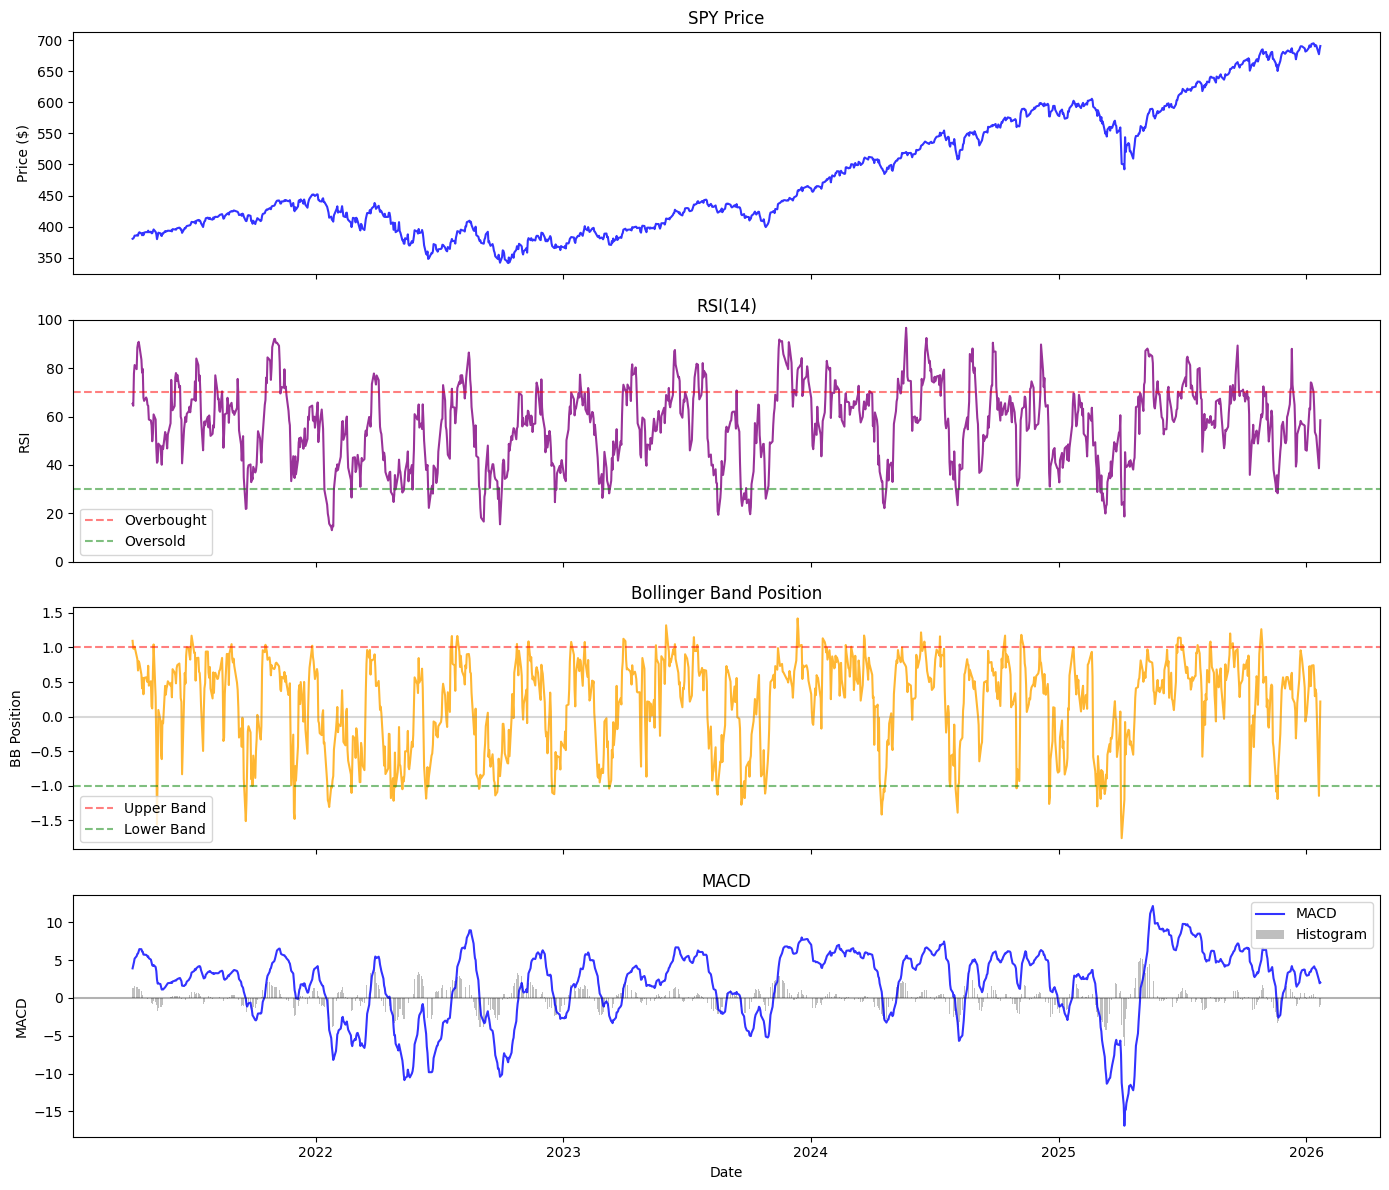

In [4]:
# Visualize key technical indicators
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Price
spy_prices = prices['SPY'].loc[features_clean.index]
axes[0].plot(spy_prices, 'b-', alpha=0.8)
axes[0].set_ylabel('Price ($)')
axes[0].set_title('SPY Price')

# RSI
axes[1].plot(features_clean['rsi_14'], 'purple', alpha=0.8)
axes[1].axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Overbought')
axes[1].axhline(y=30, color='g', linestyle='--', alpha=0.5, label='Oversold')
axes[1].set_ylabel('RSI')
axes[1].set_title('RSI(14)')
axes[1].legend()
axes[1].set_ylim(0, 100)

# Bollinger Band Position
axes[2].plot(features_clean['bb_position'], 'orange', alpha=0.8)
axes[2].axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Upper Band')
axes[2].axhline(y=-1, color='g', linestyle='--', alpha=0.5, label='Lower Band')
axes[2].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
axes[2].set_ylabel('BB Position')
axes[2].set_title('Bollinger Band Position')
axes[2].legend()

# MACD
axes[3].plot(features_clean['macd'], 'blue', alpha=0.8, label='MACD')
axes[3].bar(features_clean.index, features_clean['macd_hist'], alpha=0.5, color='gray', label='Histogram')
axes[3].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[3].set_ylabel('MACD')
axes[3].set_title('MACD')
axes[3].legend()
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

---

## 3. Feature Selection

### 🤔 Why Select Features?

Too many features can lead to:
1. **Overfitting**: Model memorizes noise
2. **Multicollinearity**: Correlated features confuse the model
3. **Computational cost**: Slower training and prediction

### Methods:

| Method | Approach |
|--------|----------|
| Correlation Filter | Remove highly correlated features |
| Variance Threshold | Remove low-variance features |
| Importance-Based | Use model feature importance |
| Recursive Elimination | Iteratively remove weakest |

In [5]:
# Prepare data for feature selection
# Target: 5-day forward return
target = returns['SPY'].shift(-5)

# Align data
common_idx = features_clean.index.intersection(target.dropna().index)
X = features_clean.loc[common_idx]
y = target.loc[common_idx]

print(f"Samples for modeling: {len(X)}")

# Time-series split (no shuffling!)
split_idx = int(len(X) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Samples for modeling: 1201
Train: 840, Test: 361


Highly Correlated Feature Pairs (|r| > 0.8):
  return_10d <-> roc_10d: 1.000
  return_5d <-> momentum_5d: 1.000
  return_20d <-> momentum_20d: 1.000
  return_1d <-> log_return_1d: 1.000
  atr_14 <-> atr_ratio: 0.972
  volatility_20d <-> atr_ratio: 0.924
  price_to_sma20 <-> bb_position: 0.917
  return_10d <-> price_to_sma20: 0.917
  roc_10d <-> price_to_sma20: 0.917
  ma_ratio_5_20 <-> price_to_sma20: 0.894


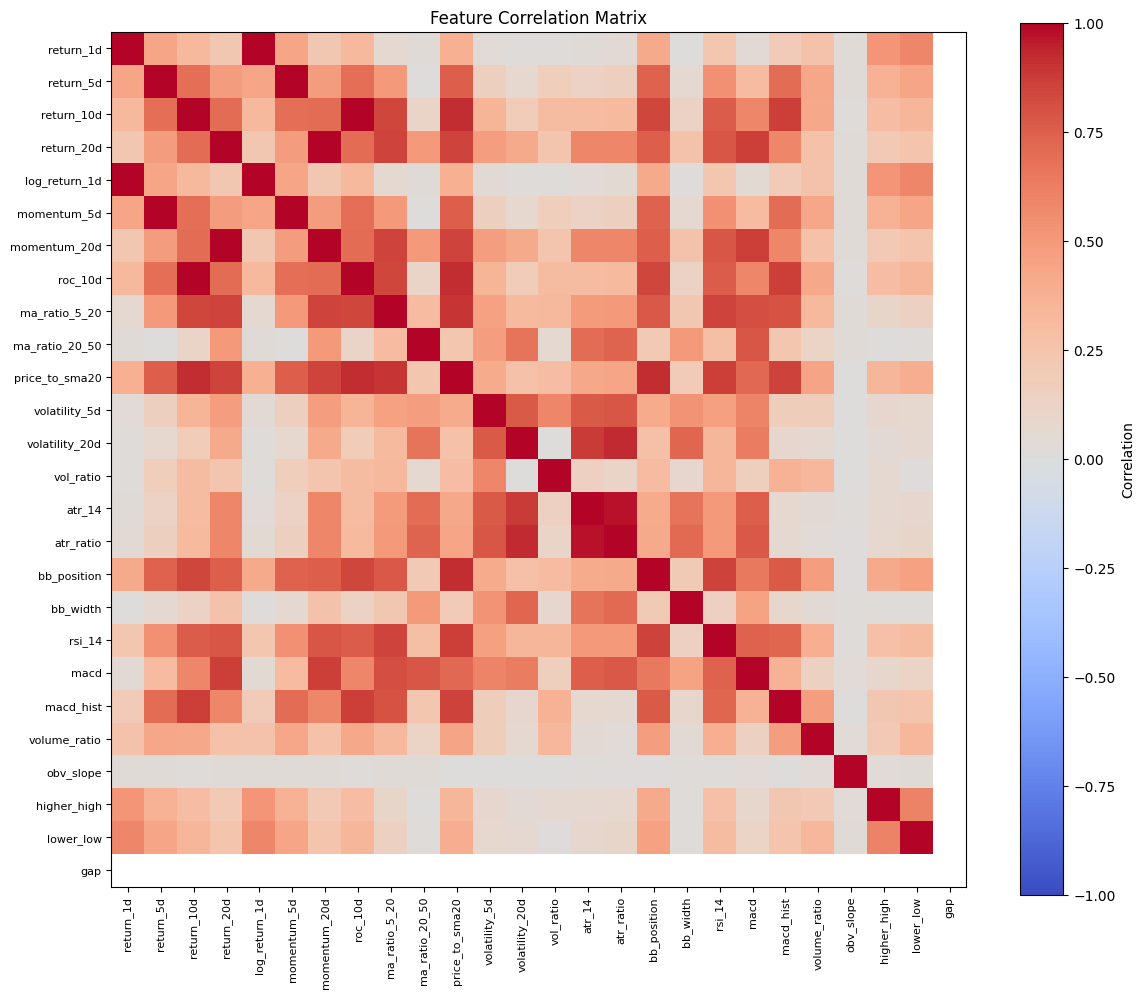

In [6]:
# Correlation analysis
corr_matrix = X_train.corr().abs()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.8:
            high_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

print("Highly Correlated Feature Pairs (|r| > 0.8):")
print("="*60)
for pair in sorted(high_corr_pairs, key=lambda x: -x['Correlation'])[:10]:
    print(f"  {pair['Feature 1']} <-> {pair['Feature 2']}: {pair['Correlation']:.3f}")

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=90, fontsize=8)
ax.set_yticklabels(corr_matrix.columns, fontsize=8)
ax.set_title('Feature Correlation Matrix')
plt.colorbar(im, ax=ax, label='Correlation')
plt.tight_layout()
plt.show()

Feature Importance (Random Forest):
       feature  importance
     atr_ratio    0.059349
ma_ratio_20_50    0.059314
 ma_ratio_5_20    0.051594
     macd_hist    0.051179
 volatility_5d    0.050320
        atr_14    0.049586
     return_5d    0.048922
     return_1d    0.047468
        rsi_14    0.047153
 log_return_1d    0.046348
volatility_20d    0.046125
  volume_ratio    0.045842
   momentum_5d    0.045495
price_to_sma20    0.043435
     vol_ratio    0.042020
     obv_slope    0.038813
      bb_width    0.037668
          macd    0.036242
       roc_10d    0.032689
   bb_position    0.032096
  momentum_20d    0.029312
    return_20d    0.025488
    return_10d    0.024866
   higher_high    0.005710
     lower_low    0.002966
           gap    0.000000

📊 Train R²: 0.8527
📊 Test R²: -0.1287


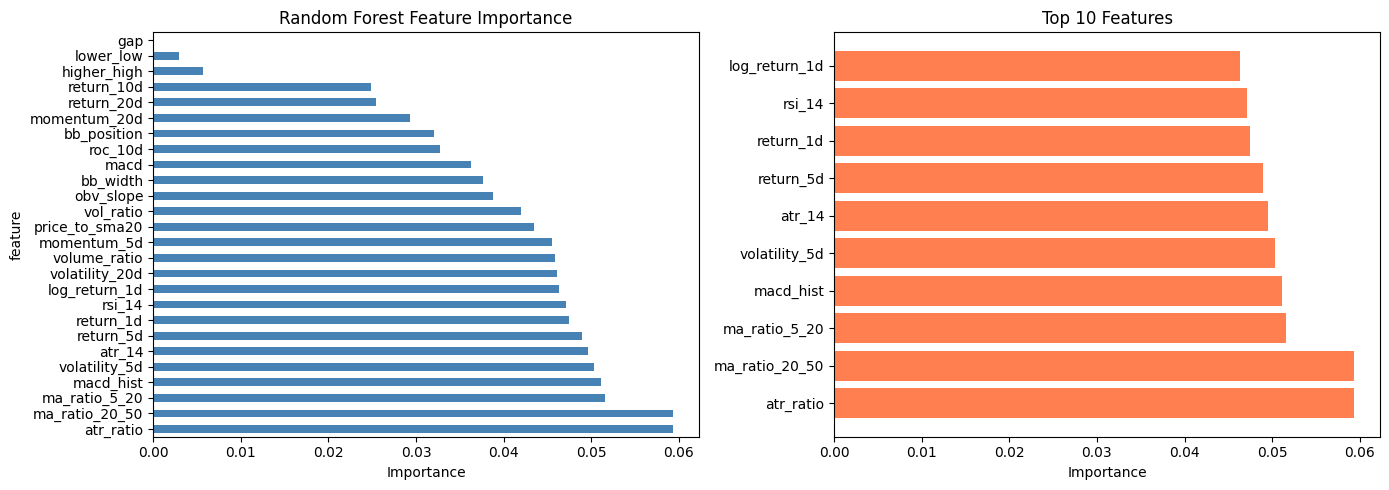

In [7]:
# Feature importance using Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

# Get feature importance
importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance (Random Forest):")
print("="*50)
print(importance.to_string(index=False))

# Model performance
train_r2 = rf.score(X_train_scaled, y_train)
test_r2 = rf.score(X_test_scaled, y_test)
print(f"\n📊 Train R²: {train_r2:.4f}")
print(f"📊 Test R²: {test_r2:.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Importance bar chart
importance.plot.barh(x='feature', y='importance', ax=axes[0], legend=False, color='steelblue')
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest Feature Importance')

# Top 10 features only for clarity
top_10 = importance.head(10)
axes[1].barh(top_10['feature'], top_10['importance'], color='coral')
axes[1].set_xlabel('Importance')
axes[1].set_title('Top 10 Features')

plt.tight_layout()
plt.show()

---

## 4. Model Explainability (SHAP)

### 🤔 What is SHAP?

SHAP (SHapley Additive exPlanations) comes from game theory. It answers:
> "How much did each feature contribute to this specific prediction?"

### Key Properties:
1. **Local accuracy**: SHAP values sum to prediction - baseline
2. **Consistency**: More important → higher SHAP value
3. **Directional**: Tells you if feature pushes prediction up or down

### Why It Matters in Finance:
- Understand what drives model decisions
- Debug unexpected predictions
- Regulatory compliance (explainable AI)

In [8]:
# SHAP Analysis
try:
    import shap
    
    print("SHAP Analysis")
    print("="*60)
    
    # Use a subset for speed
    X_explain = X_test.iloc[:200]
    X_explain_scaled = scaler.transform(X_explain)
    
    # TreeExplainer for Random Forest
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X_explain_scaled)
    
    # Global SHAP importance
    shap_importance = np.abs(shap_values).mean(axis=0)
    shap_df = pd.DataFrame({
        'feature': X.columns,
        'shap_importance': shap_importance
    }).sort_values('shap_importance', ascending=False)
    
    print("\nGlobal SHAP Importance:")
    print(shap_df.head(15).to_string(index=False))
    
    # Visualize SHAP
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Summary plot (bar)
    shap_df_top = shap_df.head(15)
    axes[0].barh(shap_df_top['feature'], shap_df_top['shap_importance'], color='steelblue')
    axes[0].set_xlabel('Mean |SHAP Value|')
    axes[0].set_title('SHAP Feature Importance (Top 15)')
    axes[0].invert_yaxis()
    
    # Compare RF importance vs SHAP
    merged = importance.merge(shap_df, on='feature')
    axes[1].scatter(merged['importance'], merged['shap_importance'], alpha=0.7)
    axes[1].set_xlabel('Random Forest Importance')
    axes[1].set_ylabel('SHAP Importance')
    axes[1].set_title('RF Importance vs SHAP Importance')
    
    # Add labels for top features
    for idx, row in merged.head(5).iterrows():
        axes[1].annotate(row['feature'], (row['importance'], row['shap_importance']), fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # SHAP summary plot (beeswarm)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_explain, feature_names=X.columns.tolist(), show=False)
    plt.title('SHAP Summary Plot')
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("⚠️ SHAP not installed. Install with: pip install shap")
    print("Skipping SHAP analysis...")

⚠️ SHAP not installed. Install with: pip install shap
Skipping SHAP analysis...


Selected Top 10 Features:
  1. atr_ratio
  2. ma_ratio_20_50
  3. ma_ratio_5_20
  4. macd_hist
  5. volatility_5d
  6. atr_14
  7. return_5d
  8. return_1d
  9. rsi_14
  10. log_return_1d

📊 Model Comparison:
All features (26): Train R² = 0.8527, Test R² = -0.1287
Top 10 features: Train R² = 0.8517, Test R² = -0.1555


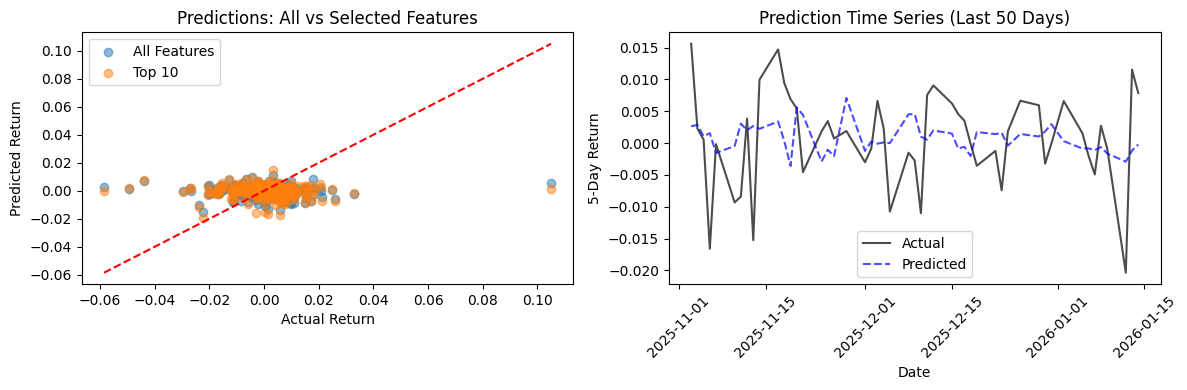

In [9]:
# Feature selection based on importance
# Select top N features
N_FEATURES = 10
top_features = importance.head(N_FEATURES)['feature'].tolist()

print(f"Selected Top {N_FEATURES} Features:")
print("="*40)
for i, f in enumerate(top_features, 1):
    print(f"  {i}. {f}")

# Train model with selected features only
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

scaler_selected = StandardScaler()
X_train_sel_scaled = scaler_selected.fit_transform(X_train_selected)
X_test_sel_scaled = scaler_selected.transform(X_test_selected)

rf_selected = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_selected.fit(X_train_sel_scaled, y_train)

train_r2_sel = rf_selected.score(X_train_sel_scaled, y_train)
test_r2_sel = rf_selected.score(X_test_sel_scaled, y_test)

print(f"\n📊 Model Comparison:")
print(f"All features ({len(X.columns)}): Train R² = {train_r2:.4f}, Test R² = {test_r2:.4f}")
print(f"Top {N_FEATURES} features: Train R² = {train_r2_sel:.4f}, Test R² = {test_r2_sel:.4f}")

# Predictions
y_pred_all = rf.predict(X_test_scaled)
y_pred_sel = rf_selected.predict(X_test_sel_scaled)

# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(y_test, y_pred_all, alpha=0.5, label='All Features')
axes[0].scatter(y_test, y_pred_sel, alpha=0.5, label=f'Top {N_FEATURES}')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_xlabel('Actual Return')
axes[0].set_ylabel('Predicted Return')
axes[0].set_title('Predictions: All vs Selected Features')
axes[0].legend()

# Prediction time series
axes[1].plot(y_test.index[-50:], y_test.values[-50:], 'k-', label='Actual', alpha=0.7)
axes[1].plot(y_test.index[-50:], y_pred_sel[-50:], 'b--', label='Predicted', alpha=0.7)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('5-Day Return')
axes[1].set_title('Prediction Time Series (Last 50 Days)')
axes[1].legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

---

## ⚠️ Common Pitfalls in Feature Engineering

### 1. Data Leakage
Using future information in features - **deadly for backtests!**

```
❌ WRONG: Using today's close to predict today's return
❌ WRONG: Normalizing with full dataset statistics
❌ WRONG: Using future earnings announcements

✅ RIGHT: Use only past data at each point
✅ RIGHT: Rolling window calculations
✅ RIGHT: Point-in-time data
```

### 2. Look-Ahead Bias
```
❌ WRONG: features = data.pct_change()  # Uses t+1 for return at t
✅ RIGHT: features = data.pct_change().shift(1)  # Past returns only
```

### 3. Survivorship Bias
Only using stocks that exist today → Overestimates performance

---

## 📊 Summary & Key Takeaways

### What We Learned:

1. **Feature Engineering**: Create meaningful signals from raw data
2. **Technical Indicators**: RSI, MACD, Bollinger Bands, etc.
3. **Feature Selection**: Remove redundant/noisy features
4. **SHAP**: Understand what drives model predictions

### Best Practices:

| Practice | Why |
|----------|-----|
| Use only past data | Prevent leakage |
| Normalize features | Fair comparison across features |
| Check correlations | Remove redundancy |
| Understand features | Economic intuition matters |

---

## 🔑 Interview Questions

1. **How do you prevent data leakage?**
2. **What makes a good trading feature?**
3. **How do you interpret SHAP values?**
4. **Why is feature selection important?**

---